# MIDI-to-audio generation 


In [1]:
import gin

gin.enter_interactive_mode()

from IPython.display import display, Audio
import torch
import numpy as np
import librosa
import matplotlib.pyplot as plt
import sys

sys.path.append('..')
torch.set_grad_enabled(False)

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Checkpoint setup

In [2]:
model_path = "/data/nils/repos/AFTER_OFFICIAL/AFTER/after_runs/drums"
step = None  # Use None to load the last
autoencoder_path = "/data/nils/repos/AFTER/pretrained/drumsv3.ts"
device = "cuda:0"

### Instantiate te model and load the checkpoint

In [3]:
from after.diffusion import RectifiedFlow

if step is None:
    files = os.listdir(model_path)
    files = [f for f in files if f.startswith("checkpoint")]
    steps = [f.split("_")[-2].replace("checkpoint", "") for f in files]
    step = max([int(s) for s in steps])
    checkpoint_file = "checkpoint" + str(step) + "_EMA.pt"

else:
    checkpoint_file = "checkpoint" + str(step) + "_EMA.pt"

print("Using checkpoint:", checkpoint_file)
checkpoint_path = os.path.join(model_path, checkpoint_file)
config = os.path.join(model_path, "config.gin")

# Parse config
gin.parse_config_file(config)
SR = gin.query_parameter("%SR")
n_signal = gin.query_parameter("%N_SIGNAL")

# Emb model

# Instantiate model
blender = RectifiedFlow(device=device)

# Load checkpoints
state_dict = torch.load(checkpoint_path, map_location="cpu")["model_state"]
blender.load_state_dict(state_dict, strict=False)

# Emb model
emb_model = torch.jit.load(autoencoder_path).eval()
blender.emb_model = emb_model

# Send to device
blender = blender.eval().to(device)

2025-07-03 12:29:56.443066: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 12:29:56.494016: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-03 12:29:57.351271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using checkpoint: checkpoint600000_EMA.pt


/data/nils/miniconda3/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipykernel_1322530/1021734282.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` fo

### Load the dataset

In [35]:
from after.dataset import SimpleDataset
from IPython.display import display, Audio

db_path = "/data/nils/datasets/instruments/handpan"
dataset = SimpleDataset(path=db_path, keys=["z", "midi"])

In [ ]:
d1 = dataset[380]
d2 = dataset[540]

z1 = d1["z"][..., :n_signal]  # guitar
z2 = d2["z"][..., :n_signal]

z1, z2 = torch.tensor(z1).to(device).unsqueeze(0), torch.tensor(z2).to(
    device).unsqueeze(0)


def normalize(array):
    return (array - array.min()) / (array.max() - array.min() + 1e-6)


ae_ratio = gin.query_parameter("utils.collate_fn.ae_ratio")
full_length = dataset[0]["z"].shape[-1]
times = times = np.linspace(0, full_length * ae_ratio / SR, full_length)

midis = [d1["midi"], d2["midi"]]
pr = [m.get_piano_roll(times=times) for m in midis]
pr = map(normalize, pr)
pr = np.stack(list(pr))
pr = pr[..., :n_signal]

pr = torch.from_numpy(pr).float().unsqueeze(1).to(device)

pr1, pr2 = pr

x1, x2 = blender.emb_model.decode(
    z1).cpu().squeeze(), blender.emb_model.decode(z2).cpu().squeeze()

display(Audio(x1, rate=SR))
plt.imshow(pr1[0].cpu().numpy(), aspect="auto", origin="lower")
plt.show()

display(Audio(x2, rate=SR))
plt.imshow(pr2[0].cpu().numpy(), aspect="auto", origin="lower")
plt.show()

#### Generation

In [7]:
nb_steps = 20  #Number of diffusion steps
guidance_timbre = 5.
guidance_structure = 1.

In [ ]:
# Compute timbre representation
zsem1, zsem2 = blender.encoder(z1), blender.encoder(z2)

time_cond = pr2
zsem = zsem1

# Sample initial noise
x0 = torch.randn_like(z1)

# Sample
xS = blender.sample(x0,
                    time_cond=time_cond,
                    cond=zsem,
                    nb_steps=nb_steps,
                    guidance_timbre=guidance_timbre,
                    guidance_structure=guidance_structure)

audio_out = blender.emb_model.decode(xS).cpu().numpy().squeeze()
display(Audio(audio_out, rate=SR))

# Sample
zsem = zsem2
xS = blender.sample(x0,
                    time_cond=time_cond,
                    cond=zsem,
                    nb_steps=nb_steps,
                    guidance_timbre=guidance_timbre,
                    guidance_structure=guidance_structure)

audio_out = blender.emb_model.decode(xS).cpu().numpy().squeeze()
display(Audio(audio_out, rate=SR))

plt.imshow(time_cond[0].cpu().numpy(), aspect="auto", origin="lower")
plt.show()


## Embedding plot

In [ ]:
from tqdm import tqdm

allzsem = []
alllabels = []
N_SIGNAL = 128

for idx in tqdm(range(len(dataset))):
    # idx = np.random.randint(0, len(dataset))
    data = dataset[idx]
    z = data["z"][..., :N_SIGNAL]
    z = torch.from_numpy(z).unsqueeze(0).float().to(device)
    label = "handpan"  #data["metadata"]["label"]
    zsem = blender.encoder(z)

    zsem = zsem.cpu().numpy().squeeze()
    allzsem.append(zsem)
    alllabels.append(label)
allzsem = np.stack(allzsem)


In [ ]:
plt.figure(figsize=(15, 10))
for i in range(allzsem.shape[1]):
    plt.subplot(2, 3, i + 1)
    plt.hist(allzsem[:, i], bins=30, alpha=0.7)
    plt.title(f"Dimension {i + 1}")
    plt.xlim(-3, 3)
plt.tight_layout()
plt.title("Dimension embedding")
plt.show()

import umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# Example embeddings and labels
embeddings = allzsem  # Replace with your (N, 6) embeddings
labels = alllabels  # Example labels
# Convert string labels to integers for coloring
label_encoder = LabelEncoder()
label_ids = label_encoder.fit_transform(labels)
label_names = label_encoder.classes_
# UMAP reduction to 2D
if embeddings.shape[-1] > 2:
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding_2d = reducer.fit_transform(embeddings)
else:
    embedding_2d = embeddings
# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding_2d[:, 0],
                      embedding_2d[:, 1],
                      c=label_ids,
                      cmap='tab10',
                      s=5)
a = torch.randn(1000, 2)
a = a * 0.025
plt.scatter(a[:, 0], a[:, 1], s=5)
plt.title("UMAP Projection Colored by Label")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
# Create a legend with string labels
handles = [
    plt.Line2D([], [],
               marker="o",
               linestyle="",
               color=scatter.cmap(scatter.norm(i)))
    for i in range(len(label_names))
]
plt.legend(handles,
           label_names,
           title="Label",
           bbox_to_anchor=(1.05, 1),
           loc='upper left')
plt.tight_layout()
plt.show()

## Map


In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm

import matplotlib.patches as mpatches
from matplotlib import cm
from scipy.ndimage import gaussian_filter
from matplotlib.colors import to_rgb

torch.set_grad_enabled(True)

from tqdm.notebook import tqdm


class SmallAutoencoder(nn.Module):

    def __init__(self, input_dim=6, latent_dim=2):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(nn.Linear(input_dim, 16), nn.GELU(),
                                     nn.Linear(16, 16), nn.GELU(),
                                     nn.Linear(16, latent_dim))
        # Decoder
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 8), nn.GELU(),
                                     nn.Linear(8, 16), nn.GELU(),
                                     nn.Linear(16, input_dim))

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent


def regularization_loss(latent_batch):
    """
    Takes a (B, 2) tensor of latent vectors and returns a scalar loss.
    Replace the body of this function with your custom regularization.
    """
    loss = torch.relu(torch.abs(latent_batch) - 1).mean()
    return loss


from sklearn.model_selection import train_test_split


def train_autoencoder(embeddings,
                      num_steps=2000,
                      batch_size=32,
                      lr=1e-3,
                      val_split=0.2,
                      device="cpu"):
    model = SmallAutoencoder(input_dim=embeddings.shape[1],
                             latent_dim=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Split train/val
    X_train, X_val = 
    est_split(embeddings,
                                      test_size=val_split,
                                      random_state=42)
    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.float32))
    val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)

    dataloader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size,
                                             shuffle=True)

    step = 0
    print("Starting training")
    stepbar = tqdm(range(num_steps), desc="Training Autoencoder")

    while step < num_steps:
        for batch in dataloader:
            model.train()
            inputs = batch[0].to(device)

            optimizer.zero_grad()
            reconstructed, latent = model(inputs)
            loss = criterion(reconstructed,
                             inputs) + regularization_loss(latent)
            loss.backward()
            optimizer.step()

            step += 1
            stepbar.update(1)

            # Validation check
            if step % (num_steps // 10) == 0 or step == 1:
                model.eval()
                with torch.no_grad():
                    val_recon, val_latent = model(val_tensor)
                    val_loss = criterion(
                        val_recon,
                        val_tensor) + regularization_loss(val_latent)

                stepbar.set_description(
                    f"Step {step} | Train: {loss.item():.4f} | Val: {val_loss.item():.4f}"
                )

            if step >= num_steps:
                break

    return model


def prepare_training(encoder, dataset, num_examples):
    print("Building dataset")

    allzsem = []
    alllabels = []
    N_SIGNAL = 128

    # for idx in tqdm(range(len(dataset))):
    for name, curdataset in dataset.datasets.items():
        if num_examples is None or num_examples > len(curdataset):
            indexes = np.arange(len(curdataset))
        else:
            indexes = np.random.choice(len(curdataset),
                                       num_examples,
                                       replace=False)
        for idx in tqdm(indexes):
            data = curdataset[idx]
            z = data["z"][..., :N_SIGNAL]
            z = torch.from_numpy(z).unsqueeze(0).float().to(device)
            label = name
            zsem = encoder(z)

            zsem = zsem.detach().cpu().numpy().squeeze()
            allzsem.append(zsem)
            alllabels.append(label)

    allzsem = np.stack(allzsem)
    return allzsem, alllabels


def generate_plot(embeddings,
                  labels,
                  use_blur=True,
                  bins=100,
                  sigma=2.0,
                  gamma=1.0,
                  brightness_scale=5.0):

    # ------------------------------------------------------------------------------
    # Embedded plotting function from your style
    # ------------------------------------------------------------------------------
    def additive_blend_blur(ax, data, labels, cmap_list, bins, sigma, gamma,
                            brightness_scale):
        unique_labels = np.unique(labels)
        n_labels = len(unique_labels)
        H = W = bins
        all_blurred = np.zeros((n_labels, H, W))
        x, y = data[:, 0], data[:, 1]
        xmin, xmax = -1.2, 1.2
        ymin, ymax = -1.2, 1.2
        xedges = np.linspace(xmin, xmax, W + 1)
        yedges = np.linspace(ymin, ymax, H + 1)

        for i, label in enumerate(unique_labels):
            xi = x[labels == label]
            yi = y[labels == label]
            hist, _, _ = np.histogram2d(xi, yi, bins=[xedges, yedges])
            if hist.sum() > 0:
                hist /= hist.sum()
            blurred = gaussian_filter(hist, sigma=sigma)
            all_blurred[i] = blurred.T**gamma

        # image = np.ones((H, W, 3))  # white base

        bg_rgb = np.array(to_rgb("#bcbcbc"))  # background color as RGB
        image = np.ones((H, W, 3)) * bg_rgb  # colored canvas
        for i, color in enumerate(cmap_list):
            norm_blur = all_blurred[i]
            norm_blur = norm_blur / norm_blur.max() if norm_blur.max(
            ) > 0 else norm_blur
            for c in range(3):
                # image[:, :, c] -= np.clip(
                #     (1 - color[c]) * norm_blur * brightness_scale, 0, 1.)
                image[:, :, c] -= np.clip(
                    (1 - color[c]) * norm_blur * brightness_scale, 0,
                    bg_rgb[c] - 0.2)

        image = np.clip(image, 0, 1)

        ax.imshow(image,
                  extent=[xmin, xmax, ymin, ymax],
                  origin='lower',
                  interpolation='bilinear')

    # ------------------------------------------------------------------------------
    # 1. Prepare data
    embedding_2d = embeddings
    background_color = "#bcbcbc"

    le = LabelEncoder()
    label_ids = le.fit_transform(labels)
    unique_labels = le.classes_
    base_cmap = cm.get_cmap('tab10', len(unique_labels))
    # colors = [base_cmap(i)[:3] for i in range(len(unique_labels))]

    base_colors = [
        # to_rgb('#e67e22'),  # orange
        to_rgb('#E24A33'),  #Strong red-orange
        to_rgb('#3498db'),  # blue
        to_rgb('#FBC15E'),  # yellow
        to_rgb('#9b59b6'),  # purple
        # to_rgb('#1abc9c'),  # turquoise
        to_rgb('#2ecc71'),  # green
    ]
    colors = [base_colors[i][:3] for i in range(len(unique_labels))]

    # ------------------------------------------------------------------------------
    # 2. Set up figure
    FIG_W, FIG_H = 8, 6
    fig = plt.figure(figsize=(FIG_W, FIG_H),
                     facecolor=background_color,
                     constrained_layout=True)
    ax = fig.add_subplot(facecolor=background_color)
    ax.axis('off')
    point_colors = np.array([colors[i] for i in label_ids])
    if use_blur:
        additive_blend_blur(ax,
                            embedding_2d,
                            label_ids,
                            colors,
                            bins=bins,
                            sigma=sigma,
                            gamma=gamma,
                            brightness_scale=brightness_scale)

        ax.scatter(
            embedding_2d[:, 0],
            embedding_2d[:, 1],
            s=0.2,
            c=point_colors,
            #    cmap=base_cmap,
            linewidths=0.03,
            alpha=0.7,
            zorder=4,
            edgecolor='white')
    else:
        ax.scatter(
            embedding_2d[:, 0],
            embedding_2d[:, 1],
            s=8,
            c=point_colors,
            #    cmap=bas\e_cmap,
            linewidths=0,
            alpha=0.8)

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(bottom=False,
                   left=False,
                   labelbottom=False,
                   labelleft=False)

    for spine in ax.spines.values():
        spine.set_color('black')

    # ------------------------------------------------------------------------------
    # Cross design and center dots
    line_length = 1.5
    dot_size = 80
    ax.plot([-line_length / 2, line_length / 2], [-1, -1],
            color='black',
            linewidth=1.5,
            zorder=2,
            alpha=0.8)
    ax.plot([-line_length / 2, line_length / 2], [1, 1],
            color='black',
            linewidth=1.5,
            zorder=2,
            alpha=0.8)
    ax.plot([-1, -1], [-line_length / 2, line_length / 2],
            color='black',
            linewidth=1.5,
            zorder=2,
            alpha=0.8)
    ax.plot([1, 1], [-line_length / 2, line_length / 2],
            color='black',
            linewidth=1.5,
            zorder=2,
            alpha=0.8)
    ax.scatter(0, 1, color='black', s=dot_size, zorder=3)
    ax.scatter(-1, 0, color='black', s=dot_size, zorder=3)
    ax.scatter(1, 0, color='black', s=dot_size, zorder=3)
    ax.scatter(0, -1, color='black', s=dot_size, zorder=3)

    plt.show()

    # ------------------------------------------------------------------------------
    # Legend
    LEGEND_WIDTH = 2
    legend_fig = plt.figure(figsize=(LEGEND_WIDTH, FIG_H),
                            facecolor=background_color)
    legend_ax = legend_fig.add_subplot(111)
    legend_ax.axis('off')
    handles = [
        mpatches.Patch(color=colors[i], label=unique_labels[i])
        for i in range(len(unique_labels))
    ]
    legend_ax.legend(handles=handles,
                     loc='center',
                     frameon=False,
                     ncol=1,
                     fontsize=10,
                     handlelength=1.5,
                     handletextpad=0.5,
                     borderaxespad=0.0,
                     borderpad=0.0,
                     labelspacing=1.2)

    return fig, legend_fig


Starting training


Training Autoencoder:   0%|          | 0/30000 [00:00<?, ?it/s]

/tmp/ipykernel_1322530/3050008479.py:205: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap('tab10', len(unique_labels))


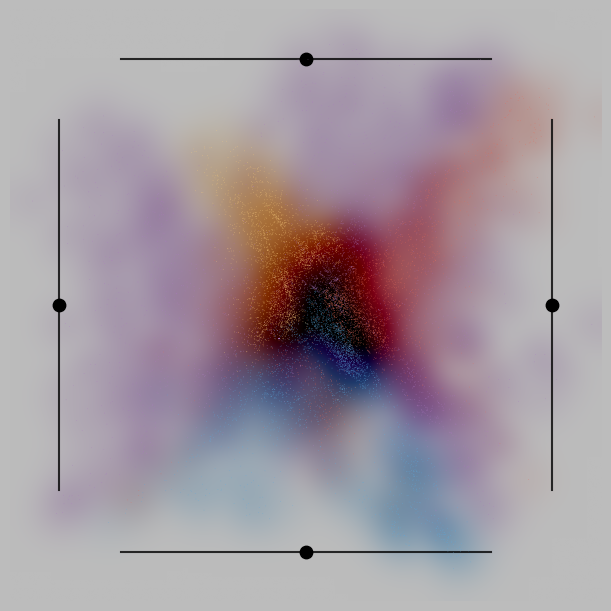

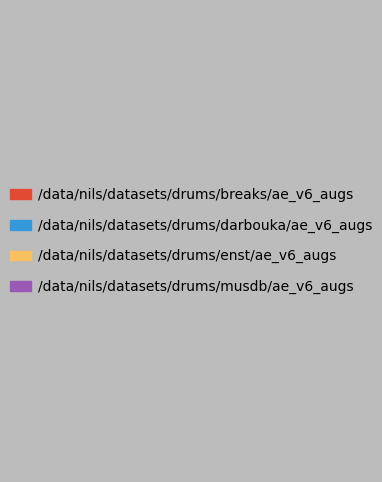

In [124]:
# from after.dataset import SimpleDataset, CombinedDataset
# from IPython.display import display, Audio

# path_dict = gin.query_parameter("utils.get_datasets.path_dict")
# dataset = CombinedDataset(path_dict=path_dict, keys=["z", "metadata"])

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# embeddings, labels = prepare_training(blender.encoder,
#                                       dataset,
#                                       num_examples=2500)
model = train_autoencoder(embeddings,
                          num_steps=30000,
                          batch_size=32,
                          lr=1e-3,
                          device="cpu")

compressed_embeddings = model.encoder(
    torch.tensor(embeddings, dtype=torch.float32)).detach().numpy()

fig, legend_fig = generate_plot(compressed_embeddings,
                                labels,
                                use_blur=True,
                                bins=500,
                                sigma=12,
                                gamma=0.5,
                                brightness_scale=1.)

In [ ]:
%matplotlib inline

In [ ]:
# out_path = '/data/nils/repos/AFTER/notebooks/afterv2.audio.drums.png'
# fig.savefig(out_path,
#                 dpi=300,
#                 bbox_inches='tight',
#                 pad_inches=0.1,
#                 facecolor=fig.get_facecolor(),
#                 transparent=False)
# legend_fig.savefig(
# '/data/nils/repos/AFTER/notebooks/afterv2.audio.drums.legend.png',
# dpi=300,
# bbox_inches='tight',
# pad_inches=0.1,
# facecolor=legend_fig.get_facecolor(),
# transparent=False)

In [45]:
%matplotlib widget

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, VBox, HBox, Output
import ipywidgets as widgets
import torch

# Assume model and embeddings_tensor are already defined
embeddings_tensor = torch.from_numpy(embeddings).float()
recon, latent = model(embeddings_tensor)
latent_points = latent.detach().numpy()

# Prepare label encoding
le = LabelEncoder()
label_ids = le.fit_transform(labels)
unique_labels = le.classes_
cmap = plt.get_cmap('tab10', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]


# Decode latent (2D → 6D)
def decode_latent_to_full(x, y):
    z = torch.tensor([[x, y]], dtype=torch.float32)
    decoded = model.decoder(z).detach().numpy().squeeze()
    return decoded


# Encode full input (6D → 2D latent)
def encode_full_to_latent(values):
    x = torch.tensor([values], dtype=torch.float32)
    latent = model.encoder(x).detach().numpy().squeeze()
    return latent


# Output widget for the plot
plot_out = Output()

# Sliders
sliders = [
    FloatSlider(min=-1, max=1, step=0.01, description=f'Var {i+1}')
    for i in range(6)
]

# Shared state
selected_point = {'x': None, 'y': None}
from_slider_update = False  # Flag to avoid feedback loop


# Update sliders from latent click
def update_sliders_from_point(x, y):
    global from_slider_update
    from_slider_update = True
    decoded = decode_latent_to_full(x, y)
    for i, val in enumerate(decoded):
        sliders[i].value = float(val)
    from_slider_update = False


# Update plot from sliders
def update_plot_from_sliders(change=None):
    if from_slider_update:
        return
    values = [slider.value for slider in sliders]
    x, y = encode_full_to_latent(values)
    selected_point['x'], selected_point['y'] = x, y
    draw_plot(x, y)


# Attach listeners to sliders
for slider in sliders:
    slider.observe(update_plot_from_sliders, names='value')


# Plot interaction
def on_click(event):
    if event.inaxes:
        x, y = event.xdata, event.ydata
        selected_point['x'], selected_point['y'] = x, y
        update_sliders_from_point(x, y)
        draw_plot(x, y)


with plot_out:
    plot_out.clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(5, 5))
    allscatter = ax.scatter(
        latent_points[:, 0],
        latent_points[:, 1],
        # color='black',
        label='Latent Points',
        c=label_ids,
        cmap=cmap,
        s=2)

    marker = ax.plot([], [], 'ro', markersize=8, label='Selected Point')[0]
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title("2D Latent Space")
    ax.legend()
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    fig.canvas.mpl_connect('button_press_event', on_click)
    plt.show()


# Plot function
def draw_plot(x_marker=None, y_marker=None):
    if x_marker is not None and y_marker is not None:

        marker.set_data([x_marker], [y_marker])


# Initial plot
draw_plot()

# Combine UI
ui = HBox([plot_out, VBox(sliders)])
ui
